# Описание проекта

В добывающей компании необходимо решить, где бурить новую скважину.<br>
Шаги для выбора локации следующие:
1. В избранном регионе собирают характеристики для скважин: качество нефти и объём её запасов;
2. Строят модель для предсказания объёма запасов в новых скважинах;
3. Выбирают скважины с самыми высокими оценками значений;
4. Определяют регион с максимальной суммарной прибылью отобранных скважин.

Предоставлены пробы нефти в трёх регионах. Характеристики для каждой скважины в регионе уже известны. Необходимо построить модель для определения региона, где добыча принесёт наибольшую прибыль. Необходимо проанализировать возможную прибыль и риски техникой `Bootstrap`.

# Оглавление

1. [Загрузка и подготовка данных](#1)
2. [Обучение и проверка модели](#2)
3. [Подготовка к расчёту прибыли](#3)
4. [Расчёт прибыли и рисков](#4)

#### Импорт библиотек

In [1]:
import pandas as pd
import numpy as np
from numpy.random import RandomState
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats as st

from IPython.display import display

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings('ignore')

# 1. <a id=1>Загрузка и подготовка данных</a>

Выгрузим датасеты в переменные region_0, region_1 и region_2.

In [2]:
region_0 = pd.read_csv('geo_data_0.csv')
region_1 = pd.read_csv('geo_data_1.csv')
region_2 = pd.read_csv('geo_data_2.csv')

`id` — уникальный идентификатор скважины;<br>
`f0, f1, f2` — три признака точек;<br>
`product` — объём запасов в скважине (тыс. баррелей).<br>

Поместим все наши регионы в один список и посмотрим как они выглядят:

In [3]:
regions = [region_0, region_1, region_2]

In [4]:
for i in range(len(regions)):
    print(f'Регион {i+1}')
    display(regions[i].head())
    print('-'*45,'\n')

Регион 1


,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


--------------------------------------------- 

Регион 2


,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


--------------------------------------------- 

Регион 3


,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


--------------------------------------------- 



Оценим размер полученного датасета и заодно проверим на пропуски:

In [5]:
for i in range(len(regions)):
    print(f'Регион {i+1}\n')
    regions[i].info()
    print('-'*45,'\n')

Регион 1

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
--------------------------------------------- 

Регион 2

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
--------------------------------------------- 

Регион 3

<class

Проверим на дубликаты. В пределах одного региона не может быть скважины с двумя данными об объёмах скважин, а если даже и одинаковые - зачем нам полные дубли строк? Предположим, это могло случиться в случае, если замеры делали в разное время (например, в момент начала бурения и через некоторе время после, для расчёта остаточного объёма нефти в скважине). Удалим дубликаты, имеющие больший запас нефти.

In [6]:
def drop_duplicated_id(data):
    """Функция удаляет дублируемую скважину с наибольшим значением столбца 'product'"""
    original = data.shape
    print((f'Изначальный размер датасета {original}'))
    data = data.sort_values(by='product', ascending=False).drop_duplicates(subset='id', keep='last')
    print(f"Удалено {original[0]-data.shape[0]} дублированных значений, с наибольшим запасом нефти. Новый размер: {data.shape}\n")
    return data.reset_index(drop=True)

In [7]:
region_0 = drop_duplicated_id(region_0)
region_1 = drop_duplicated_id(region_1)
region_2 = drop_duplicated_id(region_2)

Изначальный размер датасета (100000, 5)
Удалено 10 дублированных значений, с наибольшим запасом нефти. Новый размер: (99990, 5)

Изначальный размер датасета (100000, 5)
Удалено 4 дублированных значений, с наибольшим запасом нефти. Новый размер: (99996, 5)

Изначальный размер датасета (100000, 5)
Удалено 4 дублированных значений, с наибольшим запасом нефти. Новый размер: (99996, 5)



Также для того, чтобы уникальные идентификаторы скважин в столбце `id` не мешали обучению модели сделаем их индексами.

In [8]:
region_0.index = region_0['id'].drop(columns=['id'])
region_0.drop(columns=['id'], inplace=True)

In [9]:
region_1.index = region_1['id'].drop(columns=['id'])
region_1.drop(columns=['id'], inplace=True)

In [10]:
region_2.index = region_2['id'].drop(columns=['id'])
region_2.drop(columns=['id'], inplace=True)

Теперь приготовим данные к обучению модели. Выделим признаки `f0`, `f1`, `f2` в `features` и ключевой признак `product` в `target`, присваивая нумерацию согласно нумерации регионов.

In [11]:
r = 42
features_names = ['f0','f1','f2']
target_name = 'product'

In [12]:
def features_target(data):
    features_train, features_valid, target_train, target_valid = train_test_split(data[features_names],
                                                                                  data[target_name],
                                                                                  random_state=r,
                                                                                  test_size=.25)
    return features_train, features_valid, target_train, target_valid

In [13]:
features_train_0, features_valid_0, target_train_0, target_valid_0 = features_target(region_0)

In [14]:
features_train_1, features_valid_1, target_train_1, target_valid_1 = features_target(region_1)

In [15]:
features_train_2, features_valid_2, target_train_2, target_valid_2 = features_target(region_2)

Для анализа корреляций между `features` и `product` объединим обратно по выборкам в датасеты:

In [16]:
region_corr_0 = features_valid_0.join(target_valid_0)
region_corr_1 = features_valid_1.join(target_valid_1)
region_corr_2 = features_valid_2.join(target_valid_2)

Машстабируем признаки

In [17]:
scaler = StandardScaler()

In [18]:
def scaled_features(features_train, features_valid):
    """Функция масштабирования количественных признаков"""
    scaler.fit(features_train)
    features_train.loc[:,:] = scaler.transform(features_train)
    features_valid.loc[:,:] = scaler.transform(features_valid)
    return features_train, features_valid

In [19]:
features_train_0, features_valid_0 = scaled_features(features_train_0, features_valid_0)
features_train_1, features_valid_1 = scaled_features(features_train_1, features_valid_1)
features_train_2, features_valid_2 = scaled_features(features_train_2, features_valid_2)

# 2. <a id=2>Обучение и проверка модели</a>

Прежде чем обучать модель, проверим, подойдёт ли одна обученная модель (например на объединённых признаках) для всех регионов, или же для каждого региона желательно строить отдельную свою модель. Рассмотрим это на графиках:

<function matplotlib.pyplot.show(*args, **kw)>

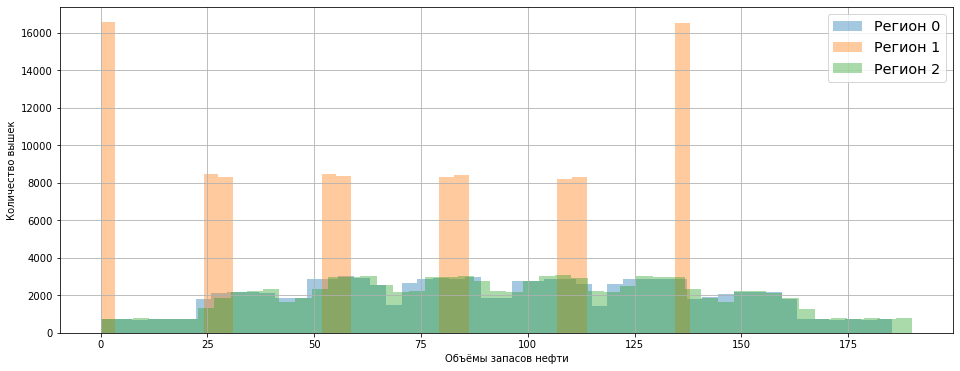

In [20]:
f, ax = plt.subplots(figsize=(16, 6))
sns.distplot(region_0['product'], ax=ax, label='Регион 0', kde=False)
sns.distplot(region_1['product'], ax=ax, label='Регион 1', kde=False)
sns.distplot(region_2['product'], ax=ax, label='Регион 2', kde=False)
ax.set(xlabel='Объёмы запасов нефти',
       ylabel='Количество вышек')
ax.grid(True)
ax.legend(fontsize='x-large')
plt.show

К сожалению, не всё так прекрасно как казалось бы. Второй регион (`region_1`) не стремится к нормальному. Если к 1 и 3 ещё можно было бы допустить применение одной модели, то к третьему нужна своя собственная.

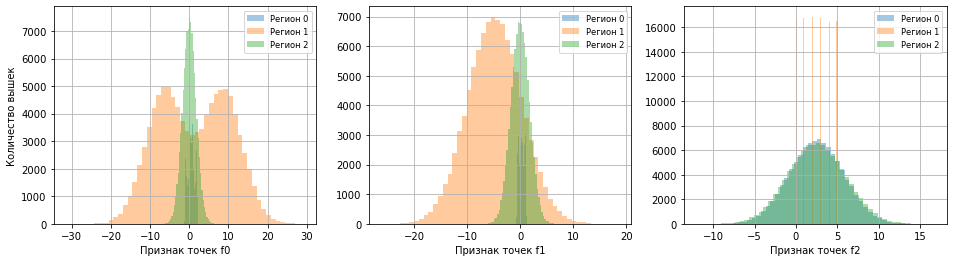

In [21]:
f, ax = plt.subplots(1, 3, figsize=(16,4))
for feat in features_names:
    sns.distplot(region_0[feat], ax=ax[features_names.index(feat)], label='Регион 0', kde=False)
    sns.distplot(region_1[feat], ax=ax[features_names.index(feat)], label='Регион 1', kde=False)
    sns.distplot(region_2[feat], ax=ax[features_names.index(feat)], label='Регион 2', kde=False)
    ax[0].set(ylabel='Количество вышек')
    ax[features_names.index(feat)].grid(True)
    ax[features_names.index(feat)].set(xlabel='Признак точек '+feat)
    ax[features_names.index(feat)].legend(fontsize='small')
plt.show()

Как мы увидели, ни точки признаков, ни объёмы нефти трёх регионов нельзя приравнять и создать одну модель для всех. Распределения как признаков, так и объёмов нести слишком разнятся для этих регионов.

Обучим модель и проверим на валидационной выборке:

In [22]:
model = LinearRegression()

In [23]:
def model_region(features_train, features_valid, target_train, target_valid):
    """Предскзание на валидационной выборке и вывод RMSE"""
    model.fit(features_train, target_train)
    predict = model.predict(features_valid)
    print(f'Средний запас фактического сырья: {round(target_valid.mean(),6)}')
    print(f'Средний запас предсказанного сырья: {round(predict.mean(),6)}')
    print(f'RMSE = {mean_squared_error(predict, target_valid)**0.5}')
    return predict

Для первого региона:

In [24]:
predictions_valid_0 = model_region(features_train_0, features_valid_0, target_train_0, target_valid_0)

Средний запас фактического сырья: 92.828544
Средний запас предсказанного сырья: 92.465985
RMSE = 37.60456458057802


Для второго региона:

In [25]:
predictions_valid_1 = model_region(features_train_1, features_valid_1, target_train_1, target_valid_1)

Средний запас фактического сырья: 69.11348
Средний запас предсказанного сырья: 69.113093
RMSE = 0.8859296808138284


Для третьего региона:

In [26]:
predictions_valid_2 = model_region(features_train_2, features_valid_2, target_train_2, target_valid_2)

Средний запас фактического сырья: 95.277765
Средний запас предсказанного сырья: 94.934521
RMSE = 39.92452149464318


Как видно, наиболее низкая среднеквадратическая ошибка RMSE во втором регионе, а значит там предсказания более точные. Скорее это всего зависит что скважины сгруппировались по объёмам нефти (как видно на графике ранее), а в первом и третьем регионах распределения более нормальны.

Посмотрим корреляции между `features` и `target` для каждого региона:

Region_0


<Figure size 576x576 with 0 Axes>

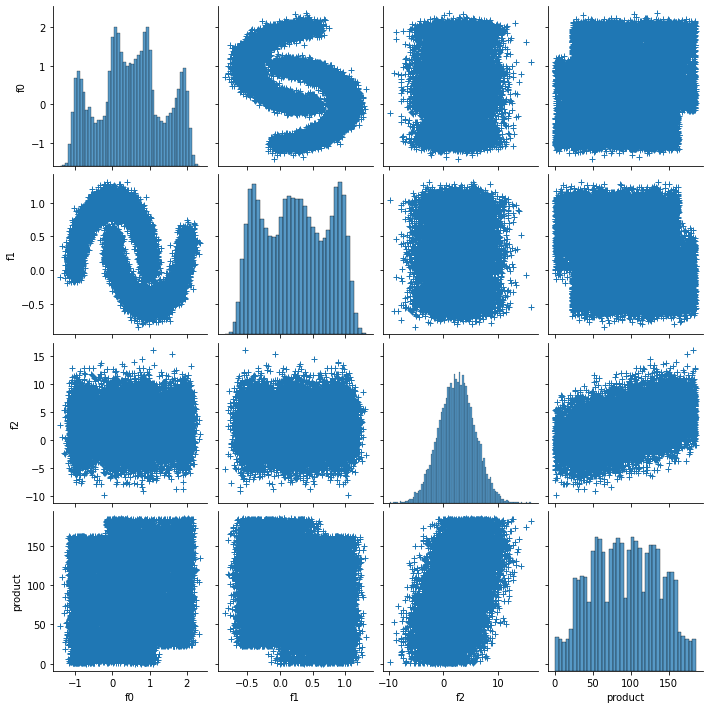

In [27]:
plt.figure(figsize=(8, 8))
print('Region_0')
sns.pairplot(region_corr_0, kind='scatter', plot_kws=dict(marker='+', linewidth=1))
plt.show()

Region_1


<Figure size 576x576 with 0 Axes>

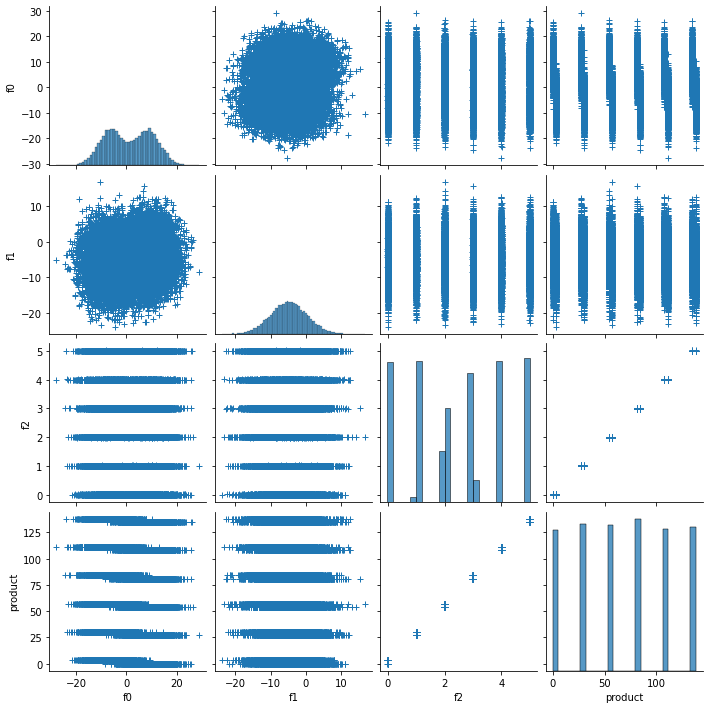

In [28]:
plt.figure(figsize=(8, 8))
print('Region_1')
sns.pairplot(region_corr_1, kind='scatter', plot_kws=dict(marker='+', linewidth=1))
plt.show()

Region_2


<Figure size 576x576 with 0 Axes>

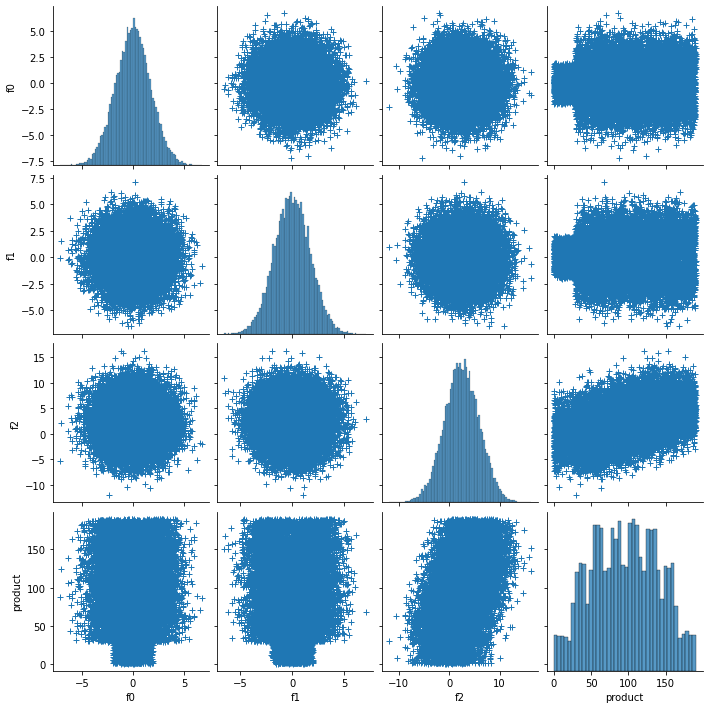

In [29]:
plt.figure(figsize=(8, 8))
print('Region_2')
sns.pairplot(region_corr_2, kind='scatter', plot_kws=dict(marker='+', linewidth=1))
plt.show()

На графиках для `Region_1` отчётливо просматривается очень сильная зависимость между точкой признака `f2` и запасами нефти `product`. Посмотрим на матрицу корреляций для этого региона:

In [30]:
region_corr_1.corr()

,f0,f1,f2,product
f0,1.000000,0.177303,-0.001157,-0.030072
f1,0.177303,1.000000,-0.001266,-0.008660
f2,-0.001157,-0.001266,1.000000,0.999391
product,-0.030072,-0.008660,0.999391,1.000000


Коэффициент Пирсона для `f2` и `product` практически равен 1. Эта сильная зависимость и помогает нашей модели лучше всего предсказывать значения запасов нефти. Возможно, произошла утечка целевого признака.

Объединим в датафрейм наши значения `product` и `predictions` для удобного расчёта прибыли и показателей в будущем.

In [31]:
region_valid_0 = pd.DataFrame(data=target_valid_0)
region_valid_0['predictions'] = predictions_valid_0

region_valid_1 = pd.DataFrame(data=target_valid_1)
region_valid_1['predictions'] = predictions_valid_1

region_valid_2 = pd.DataFrame(data=target_valid_2)
region_valid_2['predictions'] = predictions_valid_2

Получили мы такие датафреймы, с которыми удобно будет работать в дальнейшем при подсчёте прибыли и рисков.

In [32]:
display(region_valid_0.head(), region_valid_1.head(), region_valid_2.head())

,product,predictions
id,,
a3TVU,114.815156,91.979552
e1ja6,131.361049,109.018016
2kFbA,135.759406,81.549276
on7PE,153.136487,117.942297
Sal8X,157.569924,76.791026


,product,predictions
id,,
J4UIq,84.038886,83.188842
xM86z,110.992147,111.149996
I6V0V,80.859783,81.467127
TWCDD,134.766305,136.690324
VrAQY,137.945408,137.256460


,product,predictions
id,,
kw8c8,117.460257,92.243803
XzqgN,131.101287,108.492564
dqur3,105.544895,90.253867
VTnsP,155.920059,110.392329
aLfvf,160.511957,119.204380


#### Вывод
Самый низкий RMSE мы получили для `Region_1`, это значит что для данного региона предсказания будут более точные для остальных месторождений этого региона, для остальных двух регионов RMSE составляет 37-40, что означает, что при предсказании объёмов нефти в этих регионах средний "промах" от истинных объёмов нефти составляет 37-40 бареллей нефти. Разброс большой, такие разбросы могут принести или прибыли на 18-20 миллионов рублей, или наоборот, убыток.

# 3. <a id=3>Подготовка к расчёту прибыли</a>

Сохраним все ключевые значения для расчётов в отдельных переменных:

In [33]:
# бюджет на разработку скважин в регионе — 10 млрд рублей.
BUDGET = 10*10**9

# Доход с каждой единицы продукта 450 тыс. рублей
INCOME = 45*10**4

# максимальное количество разрабатываемых скважин
OIL_WELLS = 200

# количество исследуемых точек
RESEARCH_PLACES = 500

Рассчитаем достаточный объём сырья для безубыточной разработки новой скважины.

In [34]:
min_volume = round(BUDGET/OIL_WELLS/INCOME,2)
print(f'Для получения прибыли минимальный запас сырья на месторождении должен быть не меньше чем {min_volume} тыс. баррелей нефти.')

Для получения прибыли минимальный запас сырья на месторождении должен быть не меньше чем 111.11 тыс. баррелей нефти.


Сравним с фактическими запасами нефти в регионах:

In [35]:
print('Фактические средние запасы нефти в месторождениях на валидационных выборках')
print(f"в Region_0 {round(region_valid_0['product'].mean(),2)}")
print(f"в Region_1 {round(region_valid_1['product'].mean(),2)}")
print(f"в Region_2 {round(region_valid_2['product'].mean(),2)}")

Фактические средние запасы нефти в месторождениях на валидационных выборках
в Region_0 92.83
в Region_1 69.11
в Region_2 95.28


# 4. <a id=4>Расчёт прибыли и рисков</a>

Начнём считать прибыль и риски для регионов.

In [36]:
rs = np.random.RandomState(12345)
examples = 1000

In [37]:
def bootstrap_income(data):
    """Функция расчёта прибыли"""
    example = data.sample(n=RESEARCH_PLACES, replace=True, random_state=rs).sort_values(by='predictions', ascending=False).head(200)
    return round(example['product'].sum()*INCOME-BUDGET,2)

In [38]:
def analyse(data):
    """Функция анализа средней прибыли, доверительного интервала, риска убытков"""
    incomes = []
    risk = 0
    for i in range(1000):
        incomes.append(bootstrap_income(data))
        if incomes[i] < 0:
            risk += 1
    incomes = pd.Series(incomes)
   
    # расчёт средней прибыли
    incomes_mean = round(incomes.mean(),2)
    
    # расчёт доверительного интервала
    confidence_interval = st.t.interval(0.95, len(incomes)-1, incomes.mean(), incomes.sem())
    
    # расчёт риска убытков
    risk_percent = round(risk/len(incomes)*100,2)
    
    return incomes_mean, confidence_interval, risk_percent

In [39]:
income_mean_0, interval_0, risk_0 = analyse(region_valid_0)
print(f'Средняя прибыль для региона составит {income_mean_0} руб.')
print(f'95%-ый доверительный интервал: {interval_0}')
print(f'Риск убытков составляет {risk_0}')

Средняя прибыль для региона составит 389105125.7 руб.
95%-ый доверительный интервал: (373038967.8727062, 405171283.53263474)
Риск убытков составляет 7.1


In [40]:
income_mean_1, interval_1, risk_1 = analyse(region_valid_1)
print(f'Средняя прибыль для региона составит {income_mean_1} руб.')
print(f'95%-ый доверительный интервал: {interval_1}')
print(f'Риск убытков составляет {risk_1}')

Средняя прибыль для региона составит 433852765.12 руб.
95%-ый доверительный интервал: (421416642.55508924, 446288887.67964983)
Риск убытков составляет 1.3


In [41]:
income_mean_2, interval_2, risk_2 = analyse(region_valid_2)
print(f'Средняя прибыль для региона составит {income_mean_2} руб.')
print(f'95%-ый доверительный интервал: {interval_2}')
print(f'Риск убытков составляет {risk_2}')

Средняя прибыль для региона составит 367771155.43 руб.
95%-ый доверительный интервал: (351616731.95066875, 383925578.9103916)
Риск убытков составляет 7.7


Оценим среднюю прибыль регионов на графиках:

In [42]:
regions = ['Регион 1','Регион 2','Регион 3']
incomes = [[income_mean_0/1000,income_mean_1/1000,income_mean_2/1000],[risk_0,risk_1,risk_2]]
plot_income = pd.DataFrame(data=incomes,columns=regions).T.reset_index(drop=True)
plot_income.columns = ['income','risk']

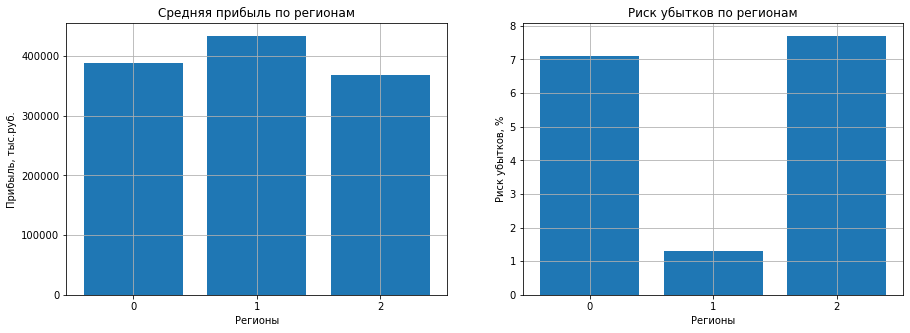

In [43]:
fig, (ax1, ax2) = plt.subplots(1,2)

ax1.bar(plot_income.index, plot_income['income'])
ax1.grid(True)
ax1.set(xticks=plot_income.index, xlabel='Регионы', ylabel='Прибыль, тыс.руб.', title='Средняя прибыль по регионам')

ax2.bar(plot_income.index, plot_income['risk'])
ax2.grid(True)
ax2.set(xticks=plot_income.index, xlabel='Регионы', ylabel='Риск убытков, %', title='Риск убытков по регионам')

fig.set_figwidth(15)
fig.set_figheight(5)
plt.show()

По графикам видно, что из представленных нам регионов - только один подходит под условия компании «ГлавРосГосНефть». `Region_1` принесёт достаточно высокую прибыль и имеет низкий риск убытков, даже не смотря на то, что средние запасы нефти там ниже, чем в остальных. `Region_0`, `Region_2` принесут прибыль меньше и с большими рисками убытков.